In [1]:
using Distributions
###########
R = 8.0; #radius of the cicle where uniform hit is generated 
#Particle 
#amorphous track parameters
E = 56.0; #C 149MeV %p 80MeV %p 18.6MeV %C 280.0Mev #He 145.74-56MeV
A = 1;
LET = 4.5; #C 149MeV 19.56 keV/um, p 80MeV 0.86(0.6) keV/um, p 18.6MeV  2.76 keV/um %C 280.0Mev 13.12 keV/um #He 145.74-56MeV 4.5
rho = 1;

par = string("He", "_", string(E));

#Time and number of particle
Dose = 12.0;
kR = 0.8;

function ATRadius(E, A, kR)

    Rc = 0.01; 

    Rp = 0.05*((E/A)^(1.7)); 

    if kR < 1.0
        Rk = Rc*exp((kR*(1+2*log(Rp/Rc))-1)/2);
    else
        Rk = Rp;
    end

    return Rc, Rp, Rk

end

(Rc, Rp, Rk) = ATRadius(E, A, kR);
println("Rc=",Rc,"\nRp=",Rp,"\nRk=",Rk)

DoseRate = 0.18; #10
DoseRate_h = DoseRate*3600;

F = Dose/(1.602*10^(-9)*LET);
Npar = round(Int, F*(pi*(R+Rk)^2*10^(-8)));
# if no simulation of time
#Np = round(Int, Dose/(1.602*10^(-9)*LET/(pi*(R+Rk)^2*10^(-8))));
#Np = Npar;

#zF = 1.602*10^(-9)*LET/(pi*(R+Rk)^2*10^(-8));
zF = Dose/Npar;
D = DoseRate_h/zF;
T = Dose/(zF*D)*3600;
#######################
function GenerateHit(R, Rk)
    
    radius = (R+Rk)*sqrt((rand(Uniform(0,1))));
    theta = 2*pi*rand(Uniform(0,1)); 
        
    x0 = radius*cos(theta);
    y0 = radius*sin(theta);
    
    return x0, y0
        
end
#######################
function GetRadialLinearDose(r)
    #LET normalized to Rk -- the cut off
    LETk = LET*0.1602;####JM: why thi is usefull?
    D_arc=0.
    if r <= Rc
        D_arc = (1/(pi*Rc^2))*(LETk/(1*(1+2*log(Rk/Rc))));
    elseif r <= Rk
        D_arc = (1/(pi*r*r))*(LETk/(1*(1+2*log(Rk/Rc))));
    end
    return D_arc
end          

Rc=0.01
Rp=46.86942766272948
Rk=7.821359928664614


GetRadialLinearDose (generic function with 1 method)

In [2]:
#Compute the angle theta in rad. of the intersection arc betweentwo circles:
#lenght of the arc=theta*r, cos(Theta)=x/r=arg
#x is here:
#https://mathworld.wolfram.com/Circle-CircleIntersection.html
function arc_intersection_angle(r, b, r_nucleus)
    if b < r_nucleus
        if r <= r_nucleus - b
            return 2 * π
        elseif r < b + r_nucleus
            arg = (b*b  + r*r  - r_nucleus * r_nucleus) / (2 * b * r)
            arg = min(arg, 1.0) #not sure if usefull?
            arg = max(arg, -1.0)
            return 2 * acos(arg)
        end
    else #(b>=r_nucleus)
        if r <= b - r_nucleus
            return 0.0 
        elseif r < b + r_nucleus
            arg =(b*b  + r*r  - r_nucleus * r_nucleus) / (2 * b * r)
            arg = min(arg, 1.0) #not sure if usefull?
            arg = max(arg, -1.0)
            return 2 * acos(arg)
        end
    end
    return 0.0
end
##############
function integrate_weighted_radial_track( rMin::Float64, rMax::Float64, b::Float64, r_nucleus::Float64, step::Int64)
        r1, r2, log_r2, log_rMin, log_rMax, log_step = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
        f1, f2, f, arc_weight1, arc_weight2 = 0.0, 0.0, 0.0, 0.0, 0.0
        integral = 0.0

        if rMin > 0
            log_rMin = log10(rMin)
        else
            log_rMin = -5.
        end

        log_rMax = log10(rMax)
        nSteps = step
        log_step = (log_rMax - log_rMin) / nSteps
        #println(log_step) 
        if nSteps < 3
            log_step = (log_rMax - log_rMin) / 3
            nSteps = 3
        end

        area = 0.0

        arc_weight2 = arc_intersection_angle(rMin, b, r_nucleus)
        f2 = GetRadialLinearDose(rMin) * rMin * arc_weight2
        r2 = rMin

        for i in 1:nSteps - 1
            log_r2 = log_rMin + log_step * (i + 1)
            f1 = f2
            r1 = r2
            arc_weight1 = arc_weight2
            #println(r2 ,"\n")
            r2 = 10^log_r2
            arc_weight2 = arc_intersection_angle(r2, b, r_nucleus)
            f2 = GetRadialLinearDose(r2) * r2 * arc_weight2
            f = (r2 - r1) * (f1 / 2.0 + f2 / 2.0)
            integral += f
            area += (r2 - r1) * (arc_weight1 * r1 / 2.0 + arc_weight2 * r2 / 2.0)
        end
        ####Pass 1<-2
        f1 = f2
        r1 = r2
        arc_weight1 = arc_weight2
        #### Fill 2
        r2 = rMax
        arc_weight2 = arc_intersection_angle(r2, b, r_nucleus)
        f2 = GetRadialLinearDose(r2) * r2 * arc_weight2
        f = (r2 - r1) * (f1 / 2.0 + f2 / 2.0)
        integral += f
        area += (r2 - r1) * (arc_weight1 * r1 / 2.0 + arc_weight2 * r2 / 2.0)

        return area, integral, integral/area
    end

#####################

integrate_weighted_radial_track (generic function with 1 method)

In [3]:
struct Cell
    x::Float64 
    y::Float64
    r::Float64
end

x=1.;
y=6.;
r=6.;# cell nucleus size 6µm

cell = Cell(x,y,r)

struct Track
    x::Float64
    y::Float64
    Rk::Float64
end

track = Track(1.,1.,Rk);

println(cell, "\n",track)

function distribute_dose(cell::Cell, track::Track)
    x_track, y_track = track.x,track.y
    x_track = (x_track - cell.x) #* 1e3  # mm -> um ??
    y_track = (y_track - cell.y) #* 1e3  # mm -> um
    b = sqrt.(x_track^2 + y_track^2)

    rMax = min.(Rk, b + cell.r)

    area1 = area2 = area3 = 0.0

    if b <= cell.r
        #nucleus.inNucleusCount += 1
        rMin = 0.0

        if b + track.Rk < cell.r
            r_intersection = track.Rk
        else
            r_intersection = cell.r - b
        end

        area1 = π * r_intersection^2
        area,integral,Gyr=integrate_weighted_radial_track(0., r_intersection, b, cell.r,1000);
        dose=integral
        # dose = track.getRadialIntegral(0.0, r_intersection) * area1

        if rMax > r_intersection
            area,integral,Gyr=integrate_weighted_radial_track(r_intersection, rMax, b, cell.r,1000);
            area2 = area #track, r_intersection, rMax, b, 0.01
            dose += integral
        end

        if rMax == track.Rk
            if track.Rk > cell.r - b
               theta1 = acos((b/(2*rMax) + rMax/(2*b) - (cell.r^2) / (2 * b * rMax)))
               theta2 = acos((b/(2*cell.r) - (rMax*rMax)/(2*b*cell.r) + (cell.r) / (2 * b)))
               area3 = π * cell.r^2 - (theta1 * track.Rk^2 + theta2 * cell.r^2 - track.Rk * b * sin(theta1))
            else
                area3 = π * (cell.r^2 - r_intersection^2)
            end
        end

        #dose /= area1 + area2 + area3
        Gyr=dose/(area1+area2+ area3)
        #println("area1: ",area1," area2: ",area2," area3: ",area3,"\n1 sumareas:",area1+area2+area3," aera cell:",cell.r*cell.r*π, "\n",area1+area2+area3-cell.r*cell.r*π)

        #nucleus.totalNucleusDose += dose
       # push!(nucleus.doses, dose)
        #push!(nucleus.times, track.getTime())

    elseif b <= cell.r + track.Rk
        #nucleus.intersectionCount += 1
        rMin = b - cell.r
        area,integral,Gyr = integrate_weighted_radial_track(rMin, rMax, b, cell.r,1000)
        dose = integral
        area2=area
        if rMax == track.Rk
            theta1 = acos((b/(2*rMax) + rMax/(2*b) - (cell.r^2) / (2 * b * rMax)))
            theta2 = acos((b/(2*cell.r) - (rMax*rMax)/(2*b*cell.r) + (cell.r) / (2 * b)))                  
            area3 = π * cell.r^2 - (theta1 * track.Rk^2 + theta2 * cell.r^2 - track.Rk * b * sin(theta1))
        end

        Gyr = dose/(area2 + area3)

        #nucleus.totalNucleusDose += dose
        #return dose, area1+area2+area3, Gyr
       # push!(cell.doses, dose)
        #push!(nucleus.times, track.getTime())
    end
    return dose, area1+area2+area3, Gyr
end

Cell(1.0, 6.0, 6.0)
Track(1.0, 1.0, 7.821359928664614)


distribute_dose (generic function with 1 method)

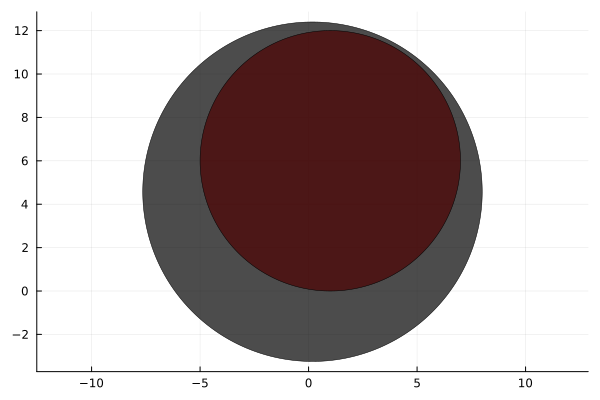

In [4]:
using Plots;
function circleShape(x,y,r)
    Theta=LinRange(0,2*π,500)
    x.+r*sin.(Theta),y.+r*cos.(Theta)
end 
function visualizeCellTrack(cell::Cell, track::Track)
    x_c,y_c,r_c=cell.x,cell.y,cell.r
    x_t,y_t,r_t=track.x,track.y,track.Rk
    plt=plot(circleShape(x_c,y_c,r_c),seriestype=:shape,fillalpha=0.7,color=:red,lw=0.5,aspect_ratio=1,legend=false)
    plot!(circleShape(x_t,y_t,r_t),seriestype=:shape,fillalpha=0.7,color=:black,lw=0.5,aspect_ratio=1,legend=false)
    return display(plt)
end
##############
x=1.;
y=6.;
r=6.;# cell nucleus size 6µm

cell = Cell(x,y,r)
xt,yt=GenerateHit(R,Rk)
track = Track(xt,yt,Rk)
distribute_dose(cell,track)
visualizeCellTrack(cell,track)


In [5]:
Np=rand(Poisson(Npar))

13178

In [7]:
@time begin
R=8.
cell=Cell(0.,0., R)
DOSE=0.
GYR=0.
for i in 1:Np
    x,y= GenerateHit(R,Rk)
    track=Track(x,y,Rk)
    dose, area, Gyr= distribute_dose(cell,track)
    DOSE+=dose
    GYR+=Gyr
    #visualizeCellTrack(cell,track)
end
end

println(DOSE)

println(GYR)

  6.810306 seconds (349.72 M allocations: 5.213 GiB, 0.50% gc time)
2407.169822311147
11.972263918756072
